# Project 3: Stock Trading Baseline

Train an RL agent to trade stocks using historical data.

**Runtime:** ~2 minutes for baseline

## Setup

In [ ]:
!pip install stable-baselines3 gym-anytrading pandas matplotlib yfinance -q

In [2]:
import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv
import yfinance as yf

## Load Historical Stock Data

Download Apple (AAPL) stock data from Yahoo Finance:

In [3]:
# Download data
ticker = 'AAPL'
start_date = '2020-01-01'
end_date = '2023-12-31'

print(f"Downloading {ticker} data from {start_date} to {end_date}...")
df = yf.download(ticker, start=start_date, end=end_date, progress=False)

df.columns = df.columns.get_level_values(0)

# Prepare data
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
df = df.dropna().reset_index(drop=True)

print(f"\nData loaded: {len(df)} days")
print(f"Date range: {df.index[0]} to {df.index[-1]}")

# Show sample
print(f"\nFirst 5 days:")
print(df.head())

C:\Users\Matias\AppData\Local\Temp\ipykernel_4460\2341817223.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)



Data loaded: 1006 days
Date range: 0 to 1005

First 5 days:
Price       Open       High        Low      Close     Volume
0      71.476607  72.528589  71.223267  72.468269  135480400
1      71.696137  72.523723  71.539307  71.763695  146322800
2      70.885457  72.374146  70.634524  72.335541  118387200
3      72.345212  72.600968  71.775796  71.995361  108872000
4      71.698596  73.455110  71.698596  73.153511  132079200


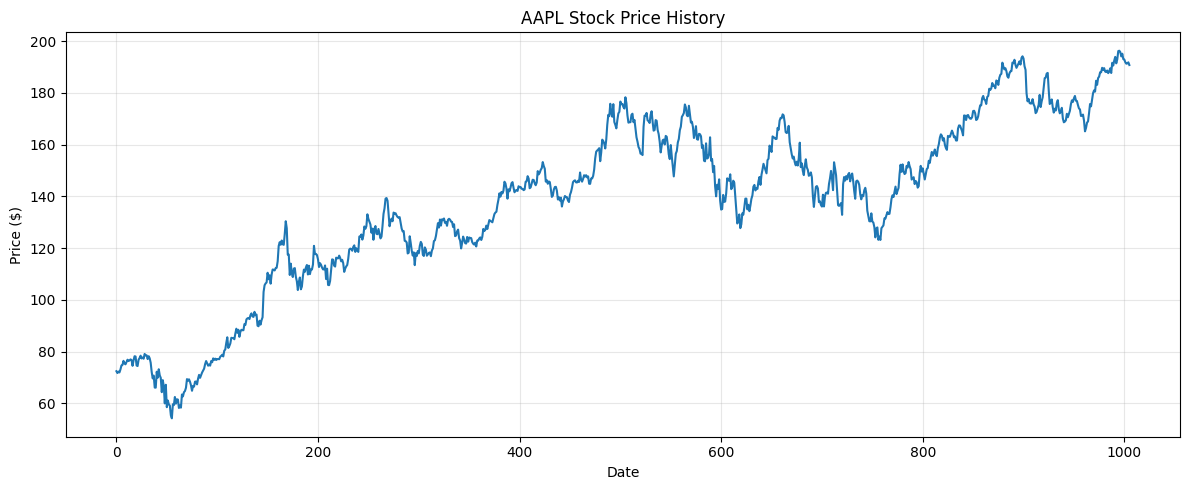


Price range: $54.26 - $196.26
Buy-and-hold return: 163.2%


In [4]:
# Plot price history
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['Close'])
plt.title(f'{ticker} Stock Price History')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Compute scalars to avoid formatting errors with pandas Series
min_price = df['Close'].min().item()
max_price = df['Close'].max().item()
bah = (df['Close'].iloc[-1].item() / df['Close'].iloc[0].item() - 1) * 100

print(f"\nPrice range: ${min_price:.2f} - ${max_price:.2f}")
print(f"Buy-and-hold return: {bah:.1f}%")

## Split Data: Train/Test

Use first 80% for training, last 20% for testing:

In [5]:
# Split data
split_idx = int(len(df) * 0.8)
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

print(f"Training data: {len(train_df)} days ({train_df.index[0]} to {train_df.index[-1]})")
print(f"Test data: {len(test_df)} days ({test_df.index[0]} to {test_df.index[-1]})")

Training data: 804 days (0 to 803)
Test data: 202 days (804 to 1005)


## Create Trading Environment

Environment features:
- **Actions**: 0=sell, 1=buy, 2=hold
- **Observation**: OHLC prices + position
- **Reward**: Profit from price changes

In [6]:
print("train_df.shape:", train_df.shape)
print("len(train_df):", len(train_df))
print("window_size:", 5)  # or your window_size variable
print(type(df.columns))
print(df.columns)


train_df.shape: (804, 5)
len(train_df): 804
window_size: 5
<class 'pandas.core.indexes.base.Index'>
Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object', name='Price')


In [7]:
# Create environment
env = gym.make(
    'stocks-v0',
    df=train_df,
    frame_bound=(5, len(train_df)),
    window_size=5
)

print(f"Environment created:")
print(f"  Observation space: {env.observation_space.shape}")
print(f"    (5 days x 5 features: OHLCV)")
print(f"  Action space: {env.action_space}")
print(f"    0=sell, 1=buy")

Environment created:
  Observation space: (5, 2)
    (5 days x 5 features: OHLCV)
  Action space: Discrete(2)
    0=sell, 1=buy


## Train Trading Agent

In [8]:
# Wrap environment
env = DummyVecEnv([lambda: gym.make('stocks-v0', df=train_df, 
                                     frame_bound=(5, len(train_df)), 
                                     window_size=5)])

# Create A2C agent
model = A2C(
    'MlpPolicy',
    env,
    learning_rate=7e-4,
    gamma=0.99,
    verbose=1,
    seed=42
)

print("\nTraining agent (~2 minutes)...\n")
model.learn(total_timesteps=50_000)
print("\nTraining complete!")

Using cpu device

Training agent (~2 minutes)...

-------------------------------------
| time/                 |           |
|    fps                | 544       |
|    iterations         | 100       |
|    time_elapsed       | 0         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -0.673    |
|    explained_variance | -6.56e-06 |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | 0.669     |
|    value_loss         | 2.4       |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 531      |
|    iterations         | 200      |
|    time_elapsed       | 1        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.693   |
|    explained_variance | 0.00225  |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy

## Backtest on Test Data

In [13]:
# Create test environment
test_env = gym.make(
    'stocks-v0',
    df=test_df,
    frame_bound=(5, len(test_df)),
    window_size=5
)

# Run agent on test data
obs, _ = test_env.reset()
done = False
actions = []
rewards = []

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = test_env.step(action)
    done = terminated or truncated
    
    actions.append(action)
    rewards.append(reward)
print(dir(test_env.unwrapped))
# Calculate metrics
env = test_env.unwrapped  # direktes Zugriff auf interne Variablen

# Gesamt-Reward und Profit
total_reward = sum(rewards)          # Summe aller Step-Rewards
total_profit = env._total_profit     # Profit in Geld
total_return = (total_profit - 1) * 100


print(f"\n{'='*50}")
print(f"Backtest Results:")
print(f"{'='*50}")
print(f"Total reward: {total_reward:.2f}")
print(f"Total profit: ${total_profit:.2f}")
print(f"Total return: {total_return:.2f}%")
print(f"Number of trades: {len(actions)}")
print(f"{'='*50}")

['__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_calculate_reward', '_current_tick', '_end_tick', '_first_rendering', '_get_info', '_get_observation', '_last_trade_tick', '_np_random', '_np_random_seed', '_position', '_position_history', '_process_data', '_render_frame', '_start_tick', '_total_profit', '_total_reward', '_truncated', '_update_history', '_update_profit', 'action_space', 'close', 'df', 'frame_bound', 'get_wrapper_attr', 'has_wrapper_attr', 'history', 'max_possible_profit', 'metadata', 'np_random', 'np_random_seed', 'observation_space', 'pause_rendering', 'prices', 

## Visualize Trading Strategy

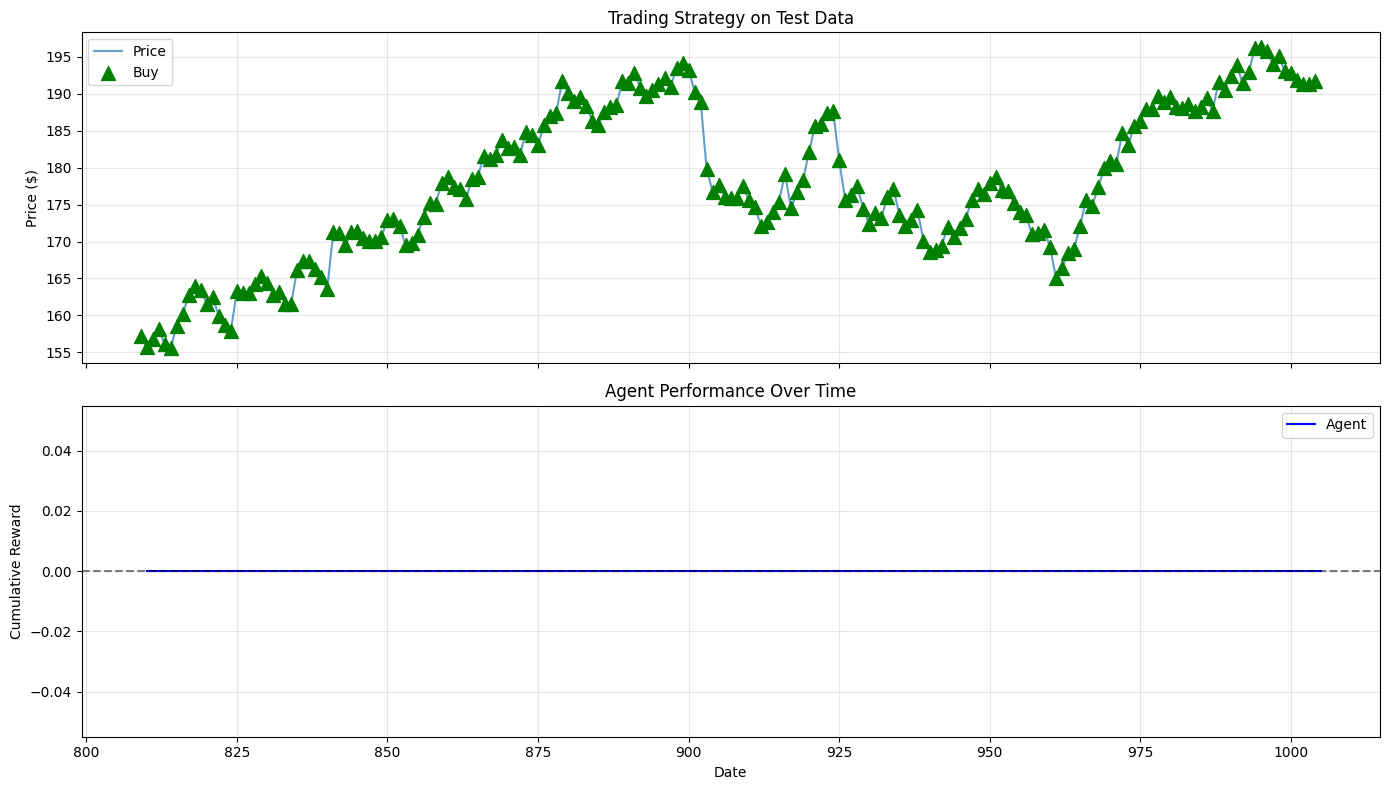


Comparison:
  Agent return: 20.65%
  Buy-and-hold return: 26.69%
  Agent underperformed. Try:
    - Training longer
    - Adding features (technical indicators)
    - Tuning hyperparameters


In [14]:
# Plot results
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Plot 1: Price and trades
prices = test_df['Close'].values[5:]  # Skip window
dates = test_df.index[5:]

axes[0].plot(dates, prices, label='Price', alpha=0.7)

# Mark buy/sell signals
buy_signals = [i for i, a in enumerate(actions) if a == 1]
sell_signals = [i for i, a in enumerate(actions) if a == 0]

if buy_signals:
    axes[0].scatter([dates[i] for i in buy_signals], 
                    [prices[i] for i in buy_signals], 
                    color='green', marker='^', s=100, label='Buy', zorder=5)

if sell_signals:
    axes[0].scatter([dates[i] for i in sell_signals], 
                    [prices[i] for i in sell_signals], 
                    color='red', marker='v', s=100, label='Sell', zorder=5)

axes[0].set_ylabel('Price ($)')
axes[0].set_title('Trading Strategy on Test Data')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Cumulative rewards
cumulative_rewards = np.cumsum(rewards)
axes[1].plot(dates[1:], cumulative_rewards, label='Agent', color='blue')
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Cumulative Reward')
axes[1].set_title('Agent Performance Over Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate buy-and-hold for comparison
bah_return = ((test_df['Close'].iloc[-1] / test_df['Close'].iloc[0]) - 1) * 100
print(f"\nComparison:")
print(f"  Agent return: {total_return:.2f}%")
print(f"  Buy-and-hold return: {bah_return:.2f}%")

if total_return > bah_return:
    print(f"  ✓ Agent outperformed buy-and-hold!")
else:
    print(f"  Agent underperformed. Try:")
    print(f"    - Training longer")
    print(f"    - Adding features (technical indicators)")
    print(f"    - Tuning hyperparameters")

In [16]:
# ------------------------------
# New agent: Technical indicators (separate model)
# ------------------------------

# Add technical indicators (work on copies so baseline is unchanged)
def add_technical_indicators(df):
    df = df.copy()
    close = df['Close']

    # Moving averages
    df['ma_10'] = close.rolling(10).mean()
    df['ema_10'] = close.ewm(span=10, adjust=False).mean()

    # RSI (14)
    delta = close.diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    roll_up = up.ewm(span=14, adjust=False).mean()
    roll_down = down.ewm(span=14, adjust=False).mean()
    rs = roll_up / (roll_down + 1e-9)
    df['rsi_14'] = 100 - (100 / (1 + rs))

    # MACD
    ema12 = close.ewm(span=12, adjust=False).mean()
    ema26 = close.ewm(span=26, adjust=False).mean()
    df['macd'] = ema12 - ema26
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['macd_hist'] = df['macd'] - df['macd_signal']

    # Bollinger Bands (20)
    ma20 = close.rolling(20).mean()
    std20 = close.rolling(20).std()
    df['bb_upper'] = ma20 + 2 * std20
    df['bb_lower'] = ma20 - 2 * std20
    df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / (ma20 + 1e-9)

    # Volume indicators (if available)
    if 'Volume' in df.columns:
        df['vol_ma_20'] = df['Volume'].rolling(20).mean()
        df['vol_ratio'] = df['Volume'] / (df['vol_ma_20'] + 1e-9)

    # Fill NaNs at the start
    df.fillna(method='bfill', inplace=True)
    df.fillna(method='ffill', inplace=True)
    return df

In [17]:
# Create new datasets
train_ind_df = add_technical_indicators(train_df)
test_ind_df = add_technical_indicators(test_df)

# Quick sanity check
print("Indicator columns added:", [c for c in train_ind_df.columns if c not in train_df.columns])


Indicator columns added: ['ma_10', 'ema_10', 'rsi_14', 'macd', 'macd_signal', 'macd_hist', 'bb_upper', 'bb_lower', 'bb_width', 'vol_ma_20', 'vol_ratio']


C:\Users\Matias\AppData\Local\Temp\ipykernel_4460\2394290533.py:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
C:\Users\Matias\AppData\Local\Temp\ipykernel_4460\2394290533.py:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
C:\Users\Matias\AppData\Local\Temp\ipykernel_4460\2394290533.py:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
C:\Users\Matias\AppData\Local\Temp\ipykernel_4460\2394290533.py:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [ ]:
# Define a lightweight custom environment that exposes indicators in the observation
class IndicatorStocksEnv(gym.Env):
    """Simple stocks env with indicator features.
    Observation: flattened window of features (window_size * n_features,)
    Actions: Discrete(2) -> 0: sell/flat, 1: buy/long
    Reward: position * price_change + realized PnL on close
    """
    metadata = {
        'render.modes': ['human']
    }

    def __init__(self, df, window_size=5, frame_bound=(5, None), reward_type='simple', risk_factor=0.01, risk_free_rate=0.0):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.window_size = window_size
        self.frame_bound = (frame_bound[0], frame_bound[1] or len(df))
        self.start = self.frame_bound[0]
        self.end = self.frame_bound[1]

        # Use Close + all additional feature columns
        base_cols = ['Close']
        self.features = base_cols + [c for c in df.columns if c not in ['Open', 'High', 'Low', 'Close', 'Date', 'Index']]
        self.feature_array = self.df[self.features].values

        # Discrete buy/sell actions (keep consistent with baseline)
        self.action_space = gym.spaces.Discrete(2)

        # Flattened observation
        n_feats = len(self.features)
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(self.window_size * n_feats,), dtype=np.float32)

        # Reward function selection
        self.reward_type = reward_type
        self.risk_factor = risk_factor
        self.risk_free_rate = risk_free_rate
        self.returns_buffer = []  # For Sharpe ratio
        self.sharpe_window = 20  # Rolling window for Sharpe

        # Initialize seed storage and set an initial seed for reproducibility
        self._seed = None
        self.seed(0)
        self.reset()

    def seed(self, seed=None):
        """Simple seeding for compatibility with SB3's DummyVecEnv.
        Returns a list with the used seed (matches gym.Env.seed convention).
        """
        if seed is None:
            seed = np.random.randint(0, 2**32 - 1)
        self._seed = int(seed)
        np.random.seed(self._seed)
        return [self._seed]

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = self.start
        self.position = 0  # 0: flat, 1: long
        self.entry_price = 0.0
        self._total_reward = 0.0
        self.returns_buffer = []
        obs = self._get_obs()
        return obs, {}

    def _get_obs(self):
        idx = self.current_step
        window = self.feature_array[idx-self.window_size:idx]
        return window.astype(np.float32).reshape(-1)

    def step(self, action):
        prev_price = self.df.loc[self.current_step - 1, 'Close']
        cur_price = self.df.loc[self.current_step, 'Close']
        price_change = cur_price - prev_price

        # Default profit calculation
        profit = self.position * price_change
        realized_pnl = 0.0

        # Action semantics (0: sell/flat, 1: buy)
        if action == 1 and self.position == 0:
            # open long
            self.position = 1
            self.entry_price = cur_price
        elif action == 0 and self.position == 1:
            # close long -> realize pnl
            realized_pnl = cur_price - self.entry_price
            self.position = 0
            self.entry_price = 0.0

        # --- Reward function selection ---
        if self.reward_type == 'simple':
            reward = profit + realized_pnl
        elif self.reward_type == 'risk_adjusted':
            risk_penalty = abs(price_change) * self.risk_factor
            reward = profit + realized_pnl - risk_penalty
        elif self.reward_type == 'sharpe':
            # Track returns for Sharpe calculation
            step_return = profit + realized_pnl
            self.returns_buffer.append(step_return)
            if len(self.returns_buffer) > self.sharpe_window:
                self.returns_buffer.pop(0)
            mean_return = np.mean(self.returns_buffer) if self.returns_buffer else 0.0
            volatility = np.std(self.returns_buffer) + 1e-9
            reward = (mean_return - self.risk_free_rate) / volatility if volatility > 0 else 0.0
        else:
            reward = profit + realized_pnl  # fallback to simple

        self._total_reward += reward
        self.current_step += 1

        terminated = False
        if self.current_step >= self.end:
            terminated = True
            # finalize position
            if self.position == 1:
                last_price = self.df.loc[self.end - 1, 'Close']
                pnl = last_price - self.entry_price
                self._total_reward += pnl
                self.position = 0

        obs = self._get_obs() if not terminated else np.zeros(self.observation_space.shape, dtype=np.float32)
        truncated = False
        info = {}
        return obs, float(reward), terminated, truncated, info

    @property
    def total_profit(self):
        return float(self._total_reward)

In [32]:
# Create vectorized environment and train a separate agent on indicator features
ind_env = DummyVecEnv([lambda: IndicatorStocksEnv(train_ind_df, window_size=5, frame_bound=(5, len(train_ind_df)))])

model_indicators = A2C('MlpPolicy', ind_env, learning_rate=7e-4, gamma=0.99, verbose=1, seed=24)
print("Training indicator agent (separate model)...")
model_indicators.learn(total_timesteps=200_000)
print("Training complete for indicators agent!")

Using cpu device
Training indicator agent (separate model)...
------------------------------------
| time/                 |          |
|    fps                | 538      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.684   |
|    explained_variance | -0.032   |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.0234  |
|    value_loss         | 0.762    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 532      |
|    iterations         | 200      |
|    time_elapsed       | 1        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.684   |
|    explained_variance | 0.00407  |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_l

In [33]:

# Backtest the new agent on test set
test_env_ind = IndicatorStocksEnv(test_ind_df, window_size=5, frame_bound=(5, len(test_ind_df)))
obs, _ = test_env_ind.reset()

done = False
actions_ind = []
rewards_ind = []


while not done:
    action, _states = model_indicators.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = test_env_ind.step(action)
    done = terminated or truncated
    actions_ind.append(int(action))
    rewards_ind.append(reward)

print('\nIndicator agent backtest results:')
print(f"Total reward: {sum(rewards_ind):.2f}")
print(f"Total profit (cumulative): {test_env_ind.total_profit:.2f}")


Indicator agent backtest results:
Total reward: 55.44
Total profit (cumulative): 55.44


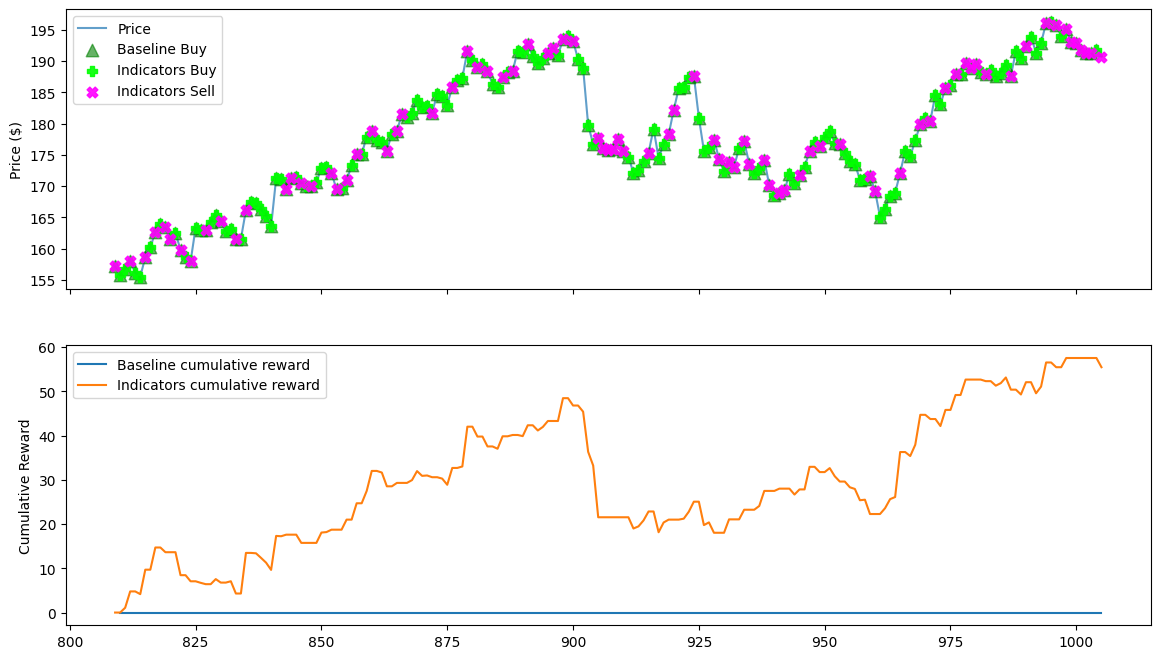

In [34]:
# Simple plot comparing baseline agent signals vs indicator agent signals
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

prices = test_df['Close'].values[5:]
df.index = pd.to_datetime(df.index)
dates = test_df.index[5:]

axes[0].plot(dates, prices, label='Price', alpha=0.7)

buy_baseline = [i for i,a in enumerate(actions) if a == 1]
sell_baseline = [i for i,a in enumerate(actions) if a == 0]

buy_ind = [i for i,a in enumerate(actions_ind) if a == 1]
sell_ind = [i for i,a in enumerate(actions_ind) if a == 0]

if buy_baseline:
    axes[0].scatter([dates[i] for i in buy_baseline], [prices[i] for i in buy_baseline], color='green', marker='^', s=80, label='Baseline Buy', zorder=5, alpha=0.6)
if sell_baseline:
    axes[0].scatter([dates[i] for i in sell_baseline], [prices[i] for i in sell_baseline], color='red', marker='v', s=80, label='Baseline Sell', zorder=5, alpha=0.6)

if buy_ind:
    axes[0].scatter([dates[i] for i in buy_ind], [prices[i] for i in buy_ind], color='lime', marker='P', s=60, label='Indicators Buy', zorder=6, alpha=0.9)
if sell_ind:
    axes[0].scatter([dates[i] for i in sell_ind], [prices[i] for i in sell_ind], color='magenta', marker='X', s=60, label='Indicators Sell', zorder=6, alpha=0.9)

axes[0].set_ylabel('Price ($)')
axes[0].legend(loc='upper left')

# Plot 2: cumulative rewards
axes[1].plot(dates[1:], np.cumsum(rewards), label='Baseline cumulative reward')
axes[1].plot(dates, np.cumsum(rewards_ind), label='Indicators cumulative reward')
axes[1].set_ylabel('Cumulative Reward')
axes[1].legend()
plt.show()

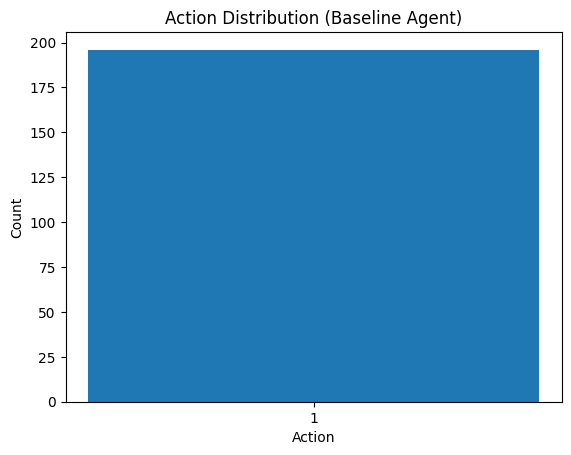

In [30]:
# Count actions
unique, counts = np.unique(actions, return_counts=True)
plt.bar(unique, counts, tick_label=[str(a) for a in unique])
plt.xlabel("Action")
plt.ylabel("Count")
plt.title("Action Distribution (Baseline Agent)")
plt.show()

In [ ]:
# Save model for later comparison
import os
os.makedirs('models', exist_ok=True)
model_indicators.save('models/a2c_indicators')
print('Saved indicators model to models/a2c_indicators')

In [24]:
print(test_df.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object', name='Price')


## Next Steps

Improve your trading agent:

1. **Add features:** Technical indicators (RSI, MACD, moving averages)
2. **Transaction costs:** Make it more realistic
3. **Risk management:** Add position sizing and stop-losses
4. **Multiple stocks:** Build a portfolio strategy
5. **Different algorithms:** Try DQN or PPO

See `project3_trading_README.md` for detailed ideas!

**⚠️ Remember:** This is for education only. Not financial advice!